In [9]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
from timeit import default_timer as timer
import itertools
from scipy.stats import sem

### dag ols v is too slow, we need to speed it up for $p = 50$.

[[ 0.5  0.   0.  ...  0.5  0.   0.5]
 [ 0.   0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.5 ... -0.5  0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ...  0.   0.5  0.5]]


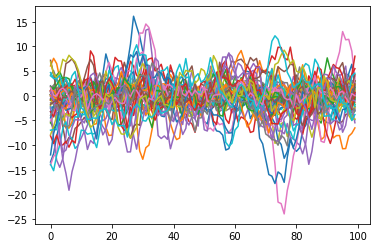

In [270]:
def gen_W(p, s, low, high, acyclic = True, regress = 0, seed = 12345):
    np.random.seed(seed)
    
    W = np.zeros((p, p))
    # randomly generate an acyclic coefficient matrix, fill diagonals
    
    if acyclic:
        # generate s off-diagonal elements uniform between +- low, high
        arcs = np.array([0.0] * (int(p * (p + 1) / 2) - s - p) + [1.0] * s)
        arcs[arcs > 0] = (2 * np.random.randint(0, 2, size=(s)) - 1) * np.random.uniform(low, high, s)
        np.random.shuffle(arcs)
    
        W[np.tril_indices(p, - 1)] = arcs
        
        P = np.random.permutation(np.identity(p))
        W = P.T @ W @ P

    #else:
        # generate acyclicly s off-diagonal elements uniform between +- low high
    
    
    # fill diagonal based on strength
    for i in range(p):
        W[i][i] = 0.5 + 0.2 * regress
        
    return W

def cov_X(W):
    
    p = np.shape(W)[0]
    # covariance matrix
    return (np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)) @ np.identity(p).reshape(p ** 2)).reshape((p, p))

def expected_cost_var(W_true, W_est):
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(cov_X(W_true), (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

def gen_var(W, T, seed = 123245):
    np.random.seed(seed)
    
    # get number of variables
    p = np.shape(W)[0]
    
    # Initialize series
    X = np.array(np.zeros((T, p)))

    # noise 
    noise = np.vstack((np.random.multivariate_normal(np.zeros(p), cov_X(W), 1), np.random.multivariate_normal(np.zeros(p), np.identity(p), T - 1)))
    X[0] = noise[0]
    
    # Generate series
    for t in range(1, T):
        # First the randomness
        X[t] = X[t - 1] @ W + noise[t]
    
    # Return series
    return X

def gen_data(p, s, T, low = 0.5, high = 0.5, regress = 0, seed = 12345):
    # generate matrix
    W = gen_W(p, min(3 * p, int(p * (p - 1) / 2)), low, high, regress = regress, seed = seed)
    
    # generate VAR(1) model in stationary distribution
    X = gen_var(W, T, seed = seed)

    return W, X, 

p, s, T = 50, 50, 100
W, X = gen_data(p = p, s = s, T = T, regress = 0, seed = 1)
print(W)
plt.plot(X);

In [271]:
def B_V_LINGNAM_OLS_2(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    W = OLS(X)
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        if np.sum(W != 0) % 5 == 0: print(np.sum(W != 0))
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
    # return the DAG W
    return W 

In [272]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h

def in_cycle(W, i, j, epsilon = 1e-32):
    
    h_val = _h(W)
    
    w_tmp = W[i][j]
    W[i][j] = 0
    h_new = _h(W)
    W[i][j] = w_tmp
    
    return np.abs(h_val - h_new) > epsilon
    
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    W = OLS(X)
    
    # non_violators
    violators = np.ones((p, p))
    
    # while we still do not have a DAG
    while not h.is_dag(W):     
        if np.sum(W != 0) % 50 == 0: print(np.sum(W != 0))
        # print(h.is_dag(W))
        
        # find edge with smallest coefficient which might be a violator
        i_list, j_list = np.where((np.abs(W) == np.min(np.abs(W[(W * violators).nonzero()]))))
        i, j = i_list[0], j_list[0]
        
        # if it is contained in a cycle, remove it
        # if not, never consider it again
        if in_cycle(W, i, j)[0]:
            W[i][j] = 0
            violators[i][j] = 0
        
            # update column
            idx = np.nonzero(W[:, j])[0]
            W[idx, j] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, j])
        else:
            violators[i][j] = 0
  
    # return the DAG W
    return W

old_time = time.time()
W = B_V_LINGNAM_OLS(X)
print(np.round(W, 2))
print(time.time() - old_time)

# old_time = time.time()
# W = B_V_LINGNAM_OLS_2(X)
# print(np.round(W, 2))
# print(time.time() - old_time)

2500
2450
2400
2350
2300
2250
2200
2150
2100
2050
2000
1950
1900
1850
1800
1750
1700
1650
1600
1550
1500
1450
1400
1350
1300
1250
1200
1150
1100
1050
1000
950
900
850
800
750
700
650
600
550
500
500
450
450
400
[[ 0.46  0.    0.   ...  0.53  0.    0.39]
 [ 0.    0.36  0.   ...  0.    0.    0.  ]
 [-0.19  0.    0.45 ... -0.43  0.   -0.17]
 ...
 [ 0.    0.    0.   ...  0.38  0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.49  0.  ]
 [ 0.    0.    0.   ...  0.    0.5   0.48]]
41.279292345047


In [254]:
print(h.is_dag(W))
print(np.where((np.abs(W) == np.min(np.abs(W[np.nonzero(W)]))))) # * violators[np.nonzero(W)]))))
print(np.round(W, 3))
print(violators)

(True, [5, 3, 9, 6, 2, 0, 4, 8, 1, 7])
(array([6], dtype=int64), array([5], dtype=int64))
[[ 0.436  0.    -0.596  0.113  0.    -0.118  0.504  0.     0.     0.378]
 [ 0.124  0.415 -0.516  0.     0.104 -0.66   0.     0.    -0.486  0.13 ]
 [ 0.     0.     0.455  0.558  0.    -0.536 -0.532  0.     0.    -0.49 ]
 [ 0.     0.     0.     0.484  0.     0.503  0.     0.     0.     0.   ]
 [ 0.486  0.    -0.62  -0.427  0.487 -0.614  0.352  0.     0.    -0.278]
 [ 0.     0.     0.     0.     0.     0.502  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.444  0.     0.074  0.45   0.     0.    -0.474]
 [-0.099  0.489  0.47  -0.465 -0.562  0.543  0.313  0.514  0.     0.54 ]
 [ 0.     0.     0.105  0.139  0.    -0.631  0.641  0.     0.539  0.   ]
 [ 0.     0.     0.    -0.522  0.     0.486  0.     0.     0.     0.474]]
[[ 0.44828285 -0.08097505 -0.58525027  0.1315694   0.09612797 -0.11831594
   0.51539776 -0.06103379  0.07787736  0.36771174]
 [ 0.15794083  0.27310273 -0.52573154  0.09797756  0.1

In [251]:
print(np.where((np.abs(W) == np.min(np.abs((W * violators).nonzero())))))
print(W[6][5])
for i in range(p):
    for j in range(p):
        print(in_cycle(W, 6, 5))

(array([0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 8, 8, 8, 9, 9, 9, 9],
      dtype=int64), array([4, 7, 3, 6, 7, 0, 1, 4, 7, 8, 0, 1, 2, 6, 7, 8, 9, 1, 7, 8, 0, 1,
       2, 3, 4, 6, 7, 8, 9, 0, 2, 4, 7, 8, 8, 0, 4, 9, 0, 1, 2, 8],
      dtype=int64))
0.07441650633997962
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False, 0.0)
(False,

### DAG-OLS-V for SEM

In [275]:
import statsmodels.api as sm
import scipy.linalg as slin

def B_V_LINGNAM_OLS_Q_SEM(X):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    B = np.ones((p, p)) - np.identity(p)
    # print(B)
    W = con_OLS(X, B != 0)
    
    # non_violators
    violators = np.ones((p, p))
    
    # while we still do not have a DAG
    while not h.is_dag(W):     
        if np.sum(W != 0) % 50 == 0: print(np.sum(W != 0))
        # print(h.is_dag(W))
        
        # find edge with smallest coefficient which might be a violator
        i_list, j_list = np.where((np.abs(W) == np.min(np.abs(W[(W * violators).nonzero()]))))
        i, j = i_list[0], j_list[0]
        
        # if it is contained in a cycle, remove it
        # if not, never consider it again
        if in_cycle(W, i, j)[0]:
            W[i][j] = 0
            violators[i][j] = 0
        
            # update column
            idx = np.nonzero(W[:, j])[0]
            W[idx, j] = (np.linalg.inv(X[:, idx].T @ X[:, idx]) @ X[:, idx].T @ X[:, j])
        else:
            violators[i][j] = 0
  
    # return the DAG W
    return W

old_time = time.time()
W = B_V_LINGNAM_OLS_Q_SEM(X)
print(np.round(W, 2))
print(time.time() - old_time)

# old_time = time.time()
# W = B_V_LINGNAM_OLS_2(X)
# print(np.round(W, 2))
# print(time.time() - old_time)

2450
2400
2350
2300
2250
2200
2150
2100
2050
2000
1950
1900
1850
1800
1750
1700
1650
1600
1550
1500
1450
1400
1350
1300
1250
1200
1150
1100
1050
1000
950
900
850
800
750
700
650
600
550
500
500
450
400
350
300
300
[[ 0.    0.    0.   ...  0.    0.    0.42]
 [ 0.    0.    0.   ... -0.27 -0.53  0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.63  0.  ]]
49.22002363204956


In [274]:
def con_OLS(X, B):
    p = np.shape(B)[0]
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ X[:, i]
        
    return W